# Machine Translation + Attention

<img src="../figures/attention1.jpg" width="800">
<img src="../figures/attention2.jpg" width="800">
<img src="../figures/attention3.jpg" width="800">

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, Dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math, time, random
from datasets import load_dataset
import pickle
import dill

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [3]:
BATCH_SIZE = 12

## 1. ETL: Loading the dataset

In [4]:
dataset = load_dataset("Verah/JParaCrawl-Filtered-English-Japanese-Parallel-Corpus", split="train").select(range(30000)).remove_columns(["id", "model1_accepted", "model2_accepted"])

In [5]:
#so this is a datapipe object; very similar to pytorch dataset version 2 which is better
dataset[0]

{'english': 'And everyone will not care that it is not you.',
 'japanese': '鼻・口のところはあらかじめ少し切っておくといいですね。'}

In [6]:
SRC_LANGUAGE = 'english'
TRG_LANGUAGE = 'japanese'

data_list = [(item[SRC_LANGUAGE], item[TRG_LANGUAGE]) for item in dataset]

In [7]:
dataset = type('CustomDataset', (Dataset,), {
    '__len__': lambda self: len(data_list),
    '__getitem__': lambda self, idx: data_list[idx]
})()

In [8]:
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - (train_size + val_size) 

## 2. EDA - simple investigation

In [9]:
#let's take a look at one example of train
sample = next(iter(dataset))
sample

('And everyone will not care that it is not you.',
 '鼻・口のところはあらかじめ少し切っておくといいですね。')

Since 29001 is plenty,, we gonna call `random_split` to train, val and test

In [10]:
train, val, test = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(999)
)

In [11]:
train_size = len(list(iter(train)))
train_size

21000

In [12]:
train_size = len(list(iter(train)))
train_size

21000

In [13]:
val_size = len(list(iter(val)))
val_size

6000

In [14]:
test_size = len(list(iter(test)))
test_size

3000

## 3. Preprocessing 

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line: 
```
python3 -m spacy download en_core_web_sm
python3 -m spacy download de_core_news_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

In [15]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [16]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='ja_core_news_sm')

In [17]:
#example of tokenization of the english part
print("Sentence: ", sample[0])
print("Tokenization: ", token_transform[SRC_LANGUAGE](sample[0]))

Sentence:  And everyone will not care that it is not you.
Tokenization:  ['And', 'everyone', 'will', 'not', 'care', 'that', 'it', 'is', 'not', 'you', '.']


A function to tokenize our input.

In [18]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]]) #either first or second index

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [19]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [20]:
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [21]:
#see some example
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[433, 19, 11, 0, 11]

In [22]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 1891, for example
mapping[1891]

'visual'

In [23]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [24]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [25]:
#check unique vocabularies
len(mapping)

9728

## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [26]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Create train, val, and test dataloaders

In [27]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_batch)
valid_loader = DataLoader(val,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

Let's test the train loader.

In [28]:
for en, _, ja in train_loader:
    break

In [29]:
print("English shape: ", en.shape)  # (seq len, batch_size)
print("Japanese shape: ", ja.shape)   # (seq len, batch_size)

English shape:  torch.Size([81, 12])
Japanese shape:  torch.Size([91, 12])


## 5. Design the model

### Seq2Seq

In [30]:
class Seq2SeqPackedAttention(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device  = device
        
    def create_mask(self, src):
        #src: [src len, batch_size]
        mask = (src == self.src_pad_idx).permute(1, 0)  #permute so that it's the same shape as attention
        #mask: [batch_size, src len] #(0, 0, 0, 0, 0, 1, 1)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        #src: [src len, batch_size]
        #trg: [trg len, batch_size]
        
        #initialize something
        batch_size = src.shape[1]
        trg_len    = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs    = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        attentions = torch.zeros(trg_len, batch_size, src.shape[0]).to(self.device)
        
        #send our src text into encoder
        encoder_outputs, hidden = self.encoder(src, src_len)
        #encoder_outputs refer to all hidden states (last layer)
        #hidden refer to the last hidden state (of each layer, of each direction)
        
        input_ = trg[0, :]
        
        mask   = self.create_mask(src) #(0, 0, 0, 0, 0, 1, 1)
        
        #for each of the input of the trg text
        for t in range(1, trg_len):
            #send them to the decoder
            output, hidden, attention = self.decoder(input_, hidden, encoder_outputs, mask)
            #output: [batch_size, output_dim] ==> predictions
            #hidden: [batch_size, hid_dim]
            #attention: [batch_size, src len]
            
            #append the output to a list
            outputs[t] = output
            attentions[t] = attention
            
            teacher_force = random.random() < teacher_forcing_ratio
            top1          = output.argmax(1)  #autoregressive
            
            input_ = trg[t] if teacher_force else top1
            
        return outputs, attentions

### Encoder

In [31]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn       = nn.GRU(emb_dim, hid_dim, bidirectional=True)
        self.fc        = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout   = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        #embedding
        embedded = self.dropout(self.embedding(src))
        #packed
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'), enforce_sorted=False)
        #rnn
        packed_outputs, hidden = self.rnn(packed_embedded)
        #unpacked
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        #-1, -2 hidden state
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim = 1)))
        
        #outputs: [src len, batch_size, hid dim * 2]
        #hidden:  [batch_size, hid_dim]
        
        return outputs, hidden
        

### Attention

The attention used here is additive attention which is defined by:

$$e = v\text{tanh}(Uh + Ws + b)$$

The `forward` method now takes a `mask` input. This is a `[batch size, source sentence length]` tensor that is 1 when the source sentence token is not a padding token, and 0 when it is a padding token. For example, if the source sentence is: `["hello", "how", "are", "you", "?", `<pad>`, `<pad>`]`, then the mask would be `[1, 1, 1, 1, 1, 0, 0]`.

We apply the mask after the attention has been calculated, but before it has been normalized by the `softmax` function. It is applied using `masked_fill`. This fills the tensor at each element where the first argument (`mask == 0`) is true, with the value given by the second argument (`-1e10`). In other words, it will take the un-normalized attention values, and change the attention values over padded elements to be `-1e10`. As these numbers will be miniscule compared to the other values they will become zero when passed through the `softmax` layer, ensuring no attention is payed to padding tokens in the source sentence.

In [32]:
class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.v = nn.Linear(hid_dim, 1, bias = False)
        self.W = nn.Linear(hid_dim, hid_dim) #for decoder input_
        self.U = nn.Linear(hid_dim * 2, hid_dim)  #for encoder_outputs
    
    def forward(self, hidden, encoder_outputs, mask):
        #hidden = [batch_size, hid_dim] ==> first hidden is basically the last hidden of the encoder
        #encoder_outputs = [src len, batch_size, hid_dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len    = encoder_outputs.shape[0]
        
        #repeat the hidden src len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        #hidden = [batch_size, src_len, hid_dim]
        
        #permute the encoder_outputs just so that you can perform multiplication / addition
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch_size, src_len, hid_dim * 2]
        
        #add
        energy = self.v(torch.tanh(self.W(hidden) + self.U(encoder_outputs))).squeeze(2)
        #(batch_size, src len, 1) ==> (batch_size, src len)
        
        #mask
        energy = energy.masked_fill(mask, -1e10)
        
        return F.softmax(energy, dim = 1)

### Decoder

In [33]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention  = attention
        self.embedding  = nn.Embedding(output_dim, emb_dim)
        self.rnn        = nn.GRU((hid_dim * 2) + emb_dim, hid_dim)
        self.fc         = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout    = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
        #input: [batch_size]
        #hidden: [batch_size, hid_dim]
        #encoder_ouputs: [src len, batch_size, hid_dim * 2]
        #mask: [batch_size, src len]
                
        #embed our input
        input    = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch_size, emb_dim]
        
        #calculate the attention
        a = self.attention(hidden, encoder_outputs, mask)
        #a = [batch_size, src len]
        a = a.unsqueeze(1)
        #a = [batch_size, 1, src len]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_ouputs: [batch_size, src len, hid_dim * 2]
        weighted = torch.bmm(a, encoder_outputs)
        #weighted: [batch_size, 1, hid_dim * 2]
        weighted = weighted.permute(1, 0, 2)
        #weighted: [1, batch_size, hid_dim * 2]
        
        #send the input to decoder rnn
            #concatenate (embed, weighted encoder_outputs)
            #[1, batch_size, emb_dim]; [1, batch_size, hid_dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        #rnn_input: [1, batch_size, emb_dim + hid_dim * 2]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
            
        #send the output of the decoder rnn to fc layer to predict the word
            #prediction = fc(concatenate (output, weighted, embed))
        embedded = embedded.squeeze(0)
        output   = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc(torch.cat((embedded, output, weighted), dim = 1))
        #prediction: [batch_size, output_dim]
            
        return prediction, hidden.squeeze(0), a.squeeze(1)

## 6. Training

We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [34]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

In [35]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 256  
hid_dim     = 512  
dropout     = 0.5
SRC_PAD_IDX = PAD_IDX

attn = Attention(hid_dim)
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

model = Seq2SeqPackedAttention(enc, dec, SRC_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(9728, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(9301, 256)
    (rnn): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=9301, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [36]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

2490368
393216
786432
  1536
  1536
393216
786432
  1536
  1536
524288
   512
   512
262144
   512
524288
   512
2381056
1966080
786432
  1536
  1536
16667392
  9301
______
27981909


Our loss function calculates the average loss per token, however by passing the index of the `<pad>` token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token. 

In [37]:
lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

The training is very similar to part 1.

In [38]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg)
        
        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [39]:
def evaluate(model, loader, criterion, loader_length):
        
    #turn off dropout (and batch norm if used)
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_length, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, attentions = model(src, src_length, trg, 0) #turn off teacher forcing

            #trg    = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

In [40]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [41]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [42]:
best_valid_loss = float('inf')
num_epochs = 4
clip       = 1

save_path = f'../../app/models/attention/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 48m 52s
Train Loss: 3.026 | Train PPL:  20.610
Val. Loss: 2.635 |  Val. PPL:  13.941
Epoch: 02 | Time: 57m 33s
Train Loss: 1.803 | Train PPL:   6.069
Val. Loss: 2.462 |  Val. PPL:  11.728
Epoch: 03 | Time: 57m 2s
Train Loss: 1.648 | Train PPL:   5.197
Val. Loss: 2.233 |  Val. PPL:   9.331
Epoch: 04 | Time: 61m 25s
Train Loss: 1.493 | Train PPL:   4.451
Val. Loss: 2.127 |  Val. PPL:   8.390


Text(0, 0.5, 'loss')

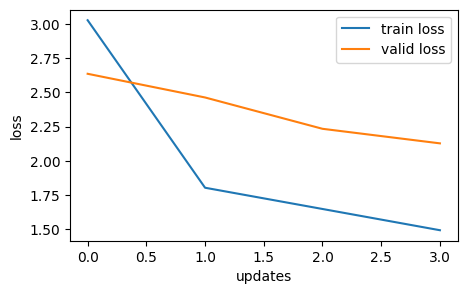

In [43]:
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [44]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.079 | Test PPL:   7.996 |


In [45]:
model

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(9728, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(9301, 256)
    (rnn): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=9301, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

## 7. Test on some random news

In [46]:
sample[0]

'And everyone will not care that it is not you.'

In [47]:
sample[1]

'鼻・口のところはあらかじめ少し切っておくといいですね。'

In [48]:
src_text = text_transform[SRC_LANGUAGE](sample[0]).to(device)
src_text

tensor([   2,  306,  656,   54,   90, 1520,   28,   37,   19,   90,   17,    5,
           3], device='cuda:0')

In [49]:
trg_text = text_transform[TRG_LANGUAGE](sample[1]).to(device)
trg_text

tensor([   2, 3969,   64,  823,    4, 1097,   10, 2470, 1072, 2666,    9, 1091,
          13,  300,   27, 1038,    8,    3], device='cuda:0')

In [50]:
src_text = src_text.reshape(-1, 1)  #because batch_size is 1

In [51]:
trg_text = trg_text.reshape(-1, 1)

In [52]:
src_text.shape, trg_text.shape

(torch.Size([13, 1]), torch.Size([18, 1]))

In [53]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [54]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, text_length, trg_text, 0) #turn off teacher forcing

In [55]:
output.shape #trg_len, batch_size, trg_output_dim

torch.Size([18, 1, 9301])

Since batch size is 1, we just take off that dimension

In [56]:
output = output.squeeze(1)

In [57]:
output.shape

torch.Size([18, 9301])

We shall remove the first token since it's zeroes anyway

In [58]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([17, 9301])

Then we just take the top token with highest probabilities

In [59]:
output_max = output.argmax(1) #returns max indices

In [60]:
output_max

tensor([99,  5,  0,  4,  4,  9,  4, 12, 69,  4, 14, 10, 69,  8,  3,  3,  8],
       device='cuda:0')

Get the mapping of the target language

In [61]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [62]:
for token in output_max:
    print(mapping[token.item()])

また
、
<unk>
の
の
て
の
が
ない
の
で
は
ない
。
<eos>
<eos>
。


## 8. Attention

Let's display the attentions to understand how the source text links with the generated text

In [63]:
attentions.shape

torch.Size([18, 1, 13])

In [64]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](sample[0]) + ['<eos>']
src_tokens

['<sos>',
 'And',
 'everyone',
 'will',
 'not',
 'care',
 'that',
 'it',
 'is',
 'not',
 'you',
 '.',
 '<eos>']

In [65]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>',
 'また',
 '、',
 '<unk>',
 'の',
 'の',
 'て',
 'の',
 'が',
 'ない',
 'の',
 'で',
 'は',
 'ない',
 '。',
 '<eos>',
 '<eos>',
 '。']

In [66]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

C:\Users\swara\AppData\Local\Temp\ipykernel_19680\140266900.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
C:\Users\swara\AppData\Local\Temp\ipykernel_19680\140266900.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)
c:\Users\swara\anaconda3\envs\nlp\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12414 (\N{HIRAGANA LETTER MA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\swara\anaconda3\envs\nlp\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12383 (\N{HIRAGANA LETTER TA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\swara\anaconda3\envs\nlp\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12289 (\N{IDEO

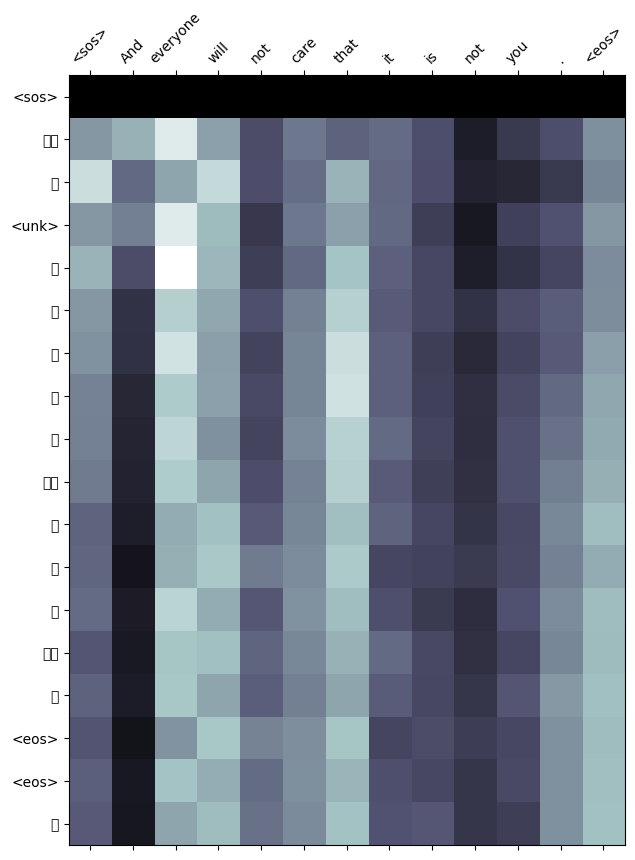

In [67]:
display_attention(src_tokens, trg_tokens, attentions)